In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F

In [6]:
chain_data = pd.read_pickle('../ethChainData/processed_data/MKR_eth_stat_pandas_1m.pickle')
print(chain_data["time"].tolist()[0])

2021-11-30 20:40:00


In [21]:
chain_data = pd.read_pickle('../ethChainData/processed_data/LINK_eth_stat_pandas_1m.pickle')
print(chain_data.isnull().values.any())
price_data = pd.read_pickle('../priceData/data/coinbase_pandas_LINK-USD_1m_2021-11-30 16:35:00_2021-12-11 19:52:00_list.pickle')
print(price_data.isnull().values.any())

False
False


In [22]:
data = pd.merge(chain_data, price_data, on='time')
print(data)

                     time    meanVolume  meanFromBalance  meanToBalance  \
0     2021-11-30 16:35:00  3.642499e+20     1.686824e+06    4791.565609   
1     2021-11-30 16:36:00  3.290219e+20     0.000000e+00  658049.550715   
2     2021-11-30 16:37:00  1.204266e+21     3.901061e+06    9583.131219   
3     2021-11-30 16:38:00  5.617914e+19     2.028188e+05  147058.317108   
4     2021-11-30 16:39:00  2.337520e+20     2.575410e+05      97.986140   
...                   ...           ...              ...            ...   
14863 2021-12-11 19:47:00  1.295969e+21     2.789912e+05   65283.437238   
14864 2021-12-11 19:49:00  2.583157e+19     1.492031e+06    1810.664895   
14865 2021-12-11 19:50:00  1.284027e+18     3.748392e+04       1.284027   
14866 2021-12-11 19:51:00  1.097508e+21     2.028490e+05  193793.580143   
14867 2021-12-11 19:52:00  9.749775e+18     0.000000e+00  178043.362814   

       medianVolume  medianFromBalance  medianToBalance     maxVolume  \
0      3.581353e+19       

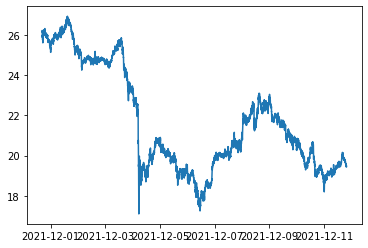

In [23]:
plt.plot(data['time'], data['open'])
plt.show()

In [24]:
dataset = data.iloc[:,1:17].values
print(len(dataset[1:3,2]))

2


In [25]:
def data_window(data, sequence_length, output_dim, leeway):
    x = []
    y = []
    
    for i in range(len(data)-sequence_length-1-leeway):
        temp_x = data[i:(i+sequence_length)]
        temp_y = data[(i+sequence_length+leeway),output_dim]
        x.append(temp_x)
        y.append(temp_y)
    return np.array(x), np.array(y).reshape(-1,1)

scaler = MinMaxScaler()
training_data = scaler.fit_transform(dataset)


sequence_length = 50
output_dim = 15 # close price
leeway = 0 # price after 1 hour
x,y = data_window(training_data, sequence_length, output_dim, leeway)

test_ratio = 0.33
train_size = int(len(y)*(1-test_ratio))
test_size = len(y) - train_size

data_x = Variable(torch.tensor(x)).float()
data_y = Variable(torch.tensor(y)).float()

train_x = Variable(torch.tensor(x[:train_size])).float()
train_y = Variable(torch.tensor(y[:train_size])).float()

test_x = Variable(torch.tensor(x[train_size:])).float()
test_y = Variable(torch.tensor(y[train_size:])).float()

In [26]:
print(train_x.shape, train_y.shape)

torch.Size([9927, 50, 16]) torch.Size([9927, 1])


In [27]:
input_dim = 16
hidden_dim = 64
num_layers = 2 
output_dim = 1

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())  

LSTM(
  (lstm): LSTM(16, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
10
torch.Size([256, 16])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([1, 64])
torch.Size([1])


In [28]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =sequence_length-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    train_y_pred = model(train_x)

    loss = loss_fn(train_y_pred, train_y)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.05481686070561409
Epoch  20 MSE:  0.013787458650767803
Epoch  30 MSE:  0.004136602394282818
Epoch  40 MSE:  0.0009767471347004175
Epoch  50 MSE:  0.0007381134200841188
Epoch  60 MSE:  0.00048161388258449733
Epoch  70 MSE:  0.0003084394265897572
Epoch  80 MSE:  0.00022314360830932856
Epoch  90 MSE:  0.0001848462561611086


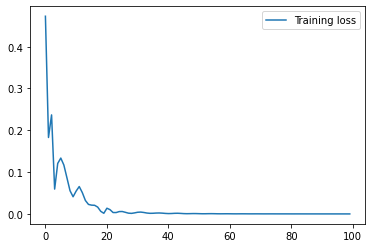

In [29]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [30]:
np.shape(train_y_pred)

torch.Size([9927, 1])

In [31]:
output_scaler = MinMaxScaler()
output_training_data = output_scaler.fit_transform(dataset[:,15].reshape(-1,1))
print(output_training_data - training_data[:,15].reshape(-1,1))

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [32]:
# make predictions
test_y_pred = model(test_x)

# invert predictions
train_y_pred = output_scaler.inverse_transform(train_y_pred.detach().numpy())
train_y = output_scaler.inverse_transform(train_y.detach().numpy())
test_y_pred = output_scaler.inverse_transform(test_y_pred.detach().numpy())
test_y = output_scaler.inverse_transform(test_y.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y[:,0], train_y_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y[:,0], test_y_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.12 RMSE
Test Score: 0.08 RMSE


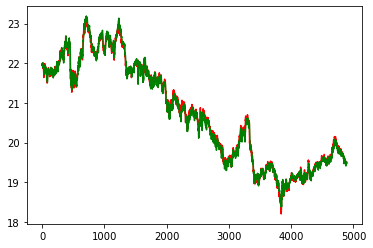

In [33]:
plt.plot(range(len(test_y)), test_y, color = 'r')
plt.plot(range(len(test_y_pred)), test_y_pred, color = 'g')
plt.show()

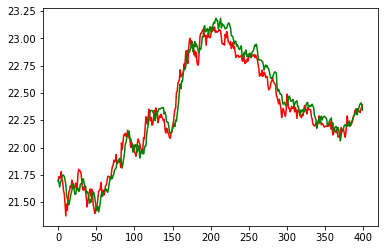

In [34]:
plt.plot(range(400), test_y[500:900], color = 'r')
plt.plot(range(400), test_y_pred[500:900], color = 'g')
plt.show()

In [31]:
print((chain_data.iloc[:,12].values.shape))

(14874,)


In [44]:

mean_volume_scaled = scale.fit_transform(chain_data['meanVolume'].values.reshape(-1,1))
print(mean_volume_scaled)

AttributeError: 'numpy.ndarray' object has no attribute 'len'

In [45]:
print(chain_data['time'][len(chain_data['time'])-1])

2021-12-11 19:52:00


In [12]:
m = nn.LogSoftmax()
input = torch.randn(2, 3)
output = F.log_softmax(input, dim=1).argmax(dim=1)
print(input, output)

tensor([[-1.2641, -1.4657,  1.5356],
        [ 0.2027,  1.2656,  1.1818]]) tensor([2, 1])


In [14]:
temp_var =-1
temp_y = [1,0] if temp_var>0 else [0,1]
print(temp_y)

[0, 1]
